<a href="https://colab.research.google.com/github/maxpilling/AI/blob/master/image_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image Classification

# Set up

## Functions and Classes

A helper function for reading in images and assigning labels.

In [ ]:
def get_meta(root_dir, dirs):
    """ Fetches the meta data for all the images and assigns labels.
    """
    paths, classes = [], []
    for i, dir_ in enumerate(dirs):
        for entry in os.scandir(root_dir + dir_):
            if (entry.is_file()):
                paths.append(entry.path)
                classes.append(i)
                
    return paths, classes

In [ ]:
def compute_img_mean_std(image_paths):
    """
        Author: @xinruizhuang. Computing the mean and std of three channel on the whole dataset,
        first we should normalize the image from 0-255 to 0-1
    """

    img_h, img_w = 224, 224
    imgs = []
    means, stdevs = [], []

    for i in tqdm(range(len(image_paths))):
        img = cv2.imread(image_paths[i])
        img = cv2.resize(img, (img_h, img_w))
        imgs.append(img)

    imgs = np.stack(imgs, axis=3)
    print(imgs.shape)

    imgs = imgs.astype(np.float32) / 255.

    for i in range(3):
        pixels = imgs[:, :, i, :].ravel()  # resize to one row
        means.append(np.mean(pixels))
        stdevs.append(np.std(pixels))

    means.reverse()  # BGR --> RGB
    stdevs.reverse()

    print("normMean = {}".format(means))
    print("normStd = {}".format(stdevs))
    return means, stdevs


In [ ]:
def train_model(num_epochs, name, save_all):
  torch.manual_seed(0)
  best_val_loss = 100000
  val_losses = []
  for epoch in range(num_epochs):
    if (save_all == True):
      torch.save(model_gpu.state_dict(), 'CurrentModel_epoch{}.pth'.format(epoch))
    
    print('Epoch {}/{}:'.format(epoch + 1, num_epochs))
    for phase in ['train', 'val']:
        
      if (phase == 'train'):
        loader = train_loader
      else:
        loader = valid_loader

      running_loss = 0.0

      for i, data in enumerate(loader, 0):
        images, labels = data

        images = images.to(device)  
        labels = labels.to(device)  

        # Zero the param gradients
        optimiser.zero_grad()

        # forward pass
        outputs = model_gpu(images)

        # compute loss
        loss = criterion(outputs, labels)

        if phase == 'train':
          # backwards pass (backpropagate the error wrt the lossforward)
          loss.backward()
          # update the parameters
          optimiser.step()

        # print the loss
        running_loss += loss.item()

        if i % 100 == 99:    # print every 100 mini-batches
            print('Batch %d - Loss: %.3f' %
                  (i + 1, running_loss / 100))
            running_loss = 0.0

      if phase == 'val':
          val_losses.append(running_loss)
          print('Validation loss: {}'.format(running_loss))
          if (running_loss < best_val_loss):
            print('Saving model.')
            best_val_loss = running_loss
            torch.save(model_gpu.state_dict(), '{}_best.pth'.format(name))

  torch.save(model_gpu.state_dict(), 'C{}_wo_val.pth'.format(name))
  plt.plot(list(range(1,num_epochs+1)), val_losses)
  plt.title('{}'.format(name))
  plt.xlabel('Epochs')
  plt.ylabel('Validation loss')
  plt.show()

In [ ]:
def test_model(model_gpu, test_loader):
  correct = 0
  total = 0
  tot_predicted = torch.zeros(0,dtype=torch.long, device='cpu')
  tot_labels    = torch.zeros(0,dtype=torch.long, device='cpu')
  # tot_predicted = torch.Tensor()
  # Why don't we need gradients? What happens if we do include gradients?
  with torch.no_grad():
      # Iterate over the test set
      i = 0
      for i, data in enumerate(test_loader, 0):
          # print('iteration {}'.format(i))
        
          images, labels = data

          images = images.to(device)  # <----------- And note it's NOT an in-place operation; original
          labels = labels.to(device)  # <----------- variables still exist on CPU
          
          outputs = model_gpu(images)
          
          # torch.max is an argmax operation
          _, predicted = torch.max(outputs.data, 1)

          total += labels.size(0)
          correct += (predicted == labels).sum().item()

          # Append batch prediction results
          tot_predicted = torch.cat([tot_predicted, predicted.view(-1).cpu()])
          tot_labels    = torch.cat([tot_labels,    labels.view(-1).cpu()])
  Accuracy = 100 * correct / total
  print('Accuracy of the network on the test images: %d %%' % (Accuracy))
  return tot_labels, tot_predicted, Accuracy

In [ ]:
import itertools

def plot_confusion_matrix(cm,
                          classes,
                          normalize=False,
                          title='5 convolutions',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix very prettily.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)

    # Specify the tick marks and axis text
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    # The data formatting
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    
    # Print the text of the matrix, adjusting text colour for display
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

In [ ]:
class ImageNet10(Dataset):
    """ ImageNet10 dataset. """

    def __init__(self, df, transform=None):
        """
        Args:
            image_dir (string): Directory with all the images
            df (DataFrame object): Dataframe containing the images, paths and classes
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        # Load image from path and get label
        x = Image.open(self.df['path'][index])
        try:
          x = x.convert('RGB') # To deal with some grayscale images in the data
        except:
          pass
        y = torch.tensor(int(self.df['class'][index]))

        if self.transform:
            x = self.transform(x)

        return x, y

### Models

In [ ]:
# Convolutional neural network
class ConvNet1(nn.Module):
    
    def __init__(self, num_classes=10):
        super(ConvNet1, self).__init__()
  
        # Add network layers here
        self.cnn_layers = nn.Sequential(
            # Convolution 1
            nn.Conv2d(3, 16, kernel_size=(3,3)),
            nn.ReLU(),
            nn.MaxPool2d((2,2)),
            nn.Dropout(p=0.3),

            nn.Flatten(),
        )

        self.linear_layers = nn.Sequential(
            nn.Linear(258064, 512),
            nn.Linear(512, num_classes),
        )

        # self.final = nn.Softmax(dim=1)
        
    def forward(self, x):

        # Complete the graph
        out = self.cnn_layers(x)
        out = self.linear_layers(out)
        return out

In [ ]:
# Convolutional neural network
class ConvNet2(nn.Module):
    
    def __init__(self, num_classes=10):
        super(ConvNet2, self).__init__()
  
        # Add network layers here
        self.cnn_layers = nn.Sequential(
            # Convolution 1
            nn.Conv2d(3, 16, kernel_size=(3,3)),
            nn.ReLU(),
            nn.MaxPool2d((2,2)),
            nn.Dropout(p=0.3),
            
            # Convolution 2
            nn.Conv2d(16, 24, kernel_size=(4,4)),
            nn.ReLU(),
            nn.MaxPool2d((2,2)),
            nn.Dropout(p=0.3),

            nn.Flatten(),
        )

        self.linear_layers = nn.Sequential(
            nn.Linear(92256, 512),
            nn.Linear(512, num_classes),
        )

        # self.final = nn.Softmax(dim=1)
        
    def forward(self, x):

        # Complete the graph
        out = self.cnn_layers(x)
        out = self.linear_layers(out)
        return out

In [ ]:
# Convolutional neural network
class ConvNet3(nn.Module):
    
    def __init__(self, num_classes=10):
        super(ConvNet3, self).__init__()
  
        # Add network layers here
        self.cnn_layers = nn.Sequential(
            # Convolution 1
            nn.Conv2d(3, 16, kernel_size=(3,3)),
            nn.ReLU(),
            nn.MaxPool2d((2,2)),
            nn.Dropout(p=0.3),
            
            # Convolution 2
            nn.Conv2d(16, 24, kernel_size=(4,4)),
            nn.ReLU(),
            nn.MaxPool2d((2,2)),
            nn.Dropout(p=0.3),

            # Convolution 3
            nn.Conv2d(24, 32, kernel_size=(4,4)),
            nn.ReLU(),
            nn.MaxPool2d((2,2)),
            nn.Dropout(p=0.3),

            nn.Flatten(),
        )

        self.linear_layers = nn.Sequential(
            nn.Linear(26912, 512),
            nn.Linear(512, num_classes),
        )

        # self.final = nn.Softmax(dim=1)
        
    def forward(self, x):

        # Complete the graph
        out = self.cnn_layers(x)
        out = self.linear_layers(out)
        return out

In [ ]:
# Convolutional neural network
class ConvNet4(nn.Module):
    
    def __init__(self, num_classes=10):
        super(ConvNet4, self).__init__()
  
        # Add network layers here
        self.cnn_layers = nn.Sequential(
            # Convolution 1
            nn.Conv2d(3, 16, kernel_size=(3,3)),
            nn.ReLU(),
            nn.MaxPool2d((2,2)),
            nn.Dropout(p=0.3),
            
            # Convolution 2
            nn.Conv2d(16, 24, kernel_size=(4,4)),
            nn.ReLU(),
            nn.MaxPool2d((2,2)),
            nn.Dropout(p=0.3),

            # Convolution 3
            nn.Conv2d(24, 32, kernel_size=(4,4)),
            nn.ReLU(),
            nn.MaxPool2d((2,2)),
            nn.Dropout(p=0.3),

            # Convolution 4
            nn.Conv2d(32, 64, kernel_size=(4,4)),
            nn.ReLU(),
            nn.MaxPool2d((2,2)),
            nn.Dropout(p=0.3),

            nn.Flatten(),
        )

        self.linear_layers = nn.Sequential(
            nn.Linear(10816, 512),
            nn.Linear(512, num_classes),
        )

        # self.final = nn.Softmax(dim=1)
        
    def forward(self, x):

        # Complete the graph
        out = self.cnn_layers(x)
        out = self.linear_layers(out)
        return out

In [ ]:
# Convolutional neural network
class ConvNet5(nn.Module):
    
    def __init__(self, num_classes=10):
        super(ConvNet5, self).__init__()
  
        # Add network layers here
        self.cnn_layers = nn.Sequential(
            # Convolution 1
            nn.Conv2d(3, 16, kernel_size=(3,3)),
            nn.ReLU(),
            nn.MaxPool2d((2,2)),
            nn.Dropout(p=0.3),
            
            # Convolution 2
            nn.Conv2d(16, 24, kernel_size=(4,4)),
            nn.ReLU(),
            nn.MaxPool2d((2,2)),
            nn.Dropout(p=0.3),

            # Convolution 3
            nn.Conv2d(24, 32, kernel_size=(4,4)),
            nn.ReLU(),
            nn.MaxPool2d((2,2)),
            nn.Dropout(p=0.3),

            # Convolution 4
            nn.Conv2d(32, 64, kernel_size=(4,4)),
            nn.ReLU(),
            nn.MaxPool2d((2,2)),
            nn.Dropout(p=0.3),

            # Convolution 5
            nn.Conv2d(64, 128, kernel_size=(5,5)),
            nn.ReLU(),
            nn.MaxPool2d((2,2)),
            nn.Dropout(p=0.3),

            nn.Flatten(),
        )

        self.linear_layers = nn.Sequential(
            nn.Linear(2048, 512),
            nn.Linear(512, num_classes),
        )

        # self.final = nn.Softmax(dim=1)
        
    def forward(self, x):

        # Complete the graph
        out = self.cnn_layers(x)
        out = self.linear_layers(out)
        return out

##### Model for part 2 and 3

In [ ]:
# Convolutional neural network
class MyConvNet(nn.Module):
    
    def __init__(self, num_classes=10):
        super(MyConvNet, self).__init__()
  
        # Add network layers here
        self.cnn_layers = nn.Sequential(
            # Convolution 1
            nn.Conv2d(3, 16, kernel_size=(3,3)),
            nn.ReLU(),
            nn.MaxPool2d((2,2)),
            nn.Dropout(p=0.3),
            
            # Convolution 2
            nn.Conv2d(16, 24, kernel_size=(4,4)),
            nn.ReLU(),
            nn.MaxPool2d((2,2)),
            nn.Dropout(p=0.3),

            # Convolution 3
            nn.Conv2d(24, 32, kernel_size=(2,2)),
            nn.ReLU(),
            nn.MaxPool2d((2,2)),
            nn.Dropout(p=0.3),

            nn.Flatten(),
        )

        self.linear_layers = nn.Sequential(
            nn.Linear(28800, 512),
            nn.Linear(512, num_classes),
        )

        # self.final = nn.Softmax(dim=1)
        
    def forward(self, x):

        # Complete the graph
        out = self.cnn_layers(x)
        out = self.linear_layers(out)
        return out

In [ ]:
train_loader = torch.utils.data.DataLoader(
    ins_dataset_train,
    batch_size=16,
    shuffle=True,
    num_workers=2
)

valid_loader = torch.utils.data.DataLoader(
    ins_dataset_valid,
    batch_size=16,
    shuffle=True,
    num_workers=2
)


test_loader = torch.utils.data.DataLoader(
    ins_dataset_test,
    batch_size=24,
    shuffle=False,
    num_workers=2
)

## Requirements

In [ ]:
import torch
import torchvision
import torch.optim as optim
import torch.nn as nn
import torchvision.transforms as transforms
from  torch.utils.data import Dataset

from sklearn.metrics import confusion_matrix
from skimage import io, transform

import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image
import pandas as pd
import numpy as np
import csv
import os
import math
import cv2

In [ ]:
! git clone https://github.com/MohammedAlghamdi/imagenet10.git

Cloning into 'imagenet10'...
remote: Enumerating objects: 10019, done.
remote: Total 10019 (delta 0), reused 0 (delta 0), pack-reused 10019
Receiving objects: 100% (10019/10019), 966.71 MiB | 56.33 MiB/s, done.
Resolving deltas: 100% (2/2), done.
Checking out files: 100% (10002/10002), done.


Check that the repository is there:

In [ ]:
! ls

sample_data


In [ ]:
root_dir = "imagenet10/train_set/"
class_names = [
  "baboon",
  "banana",
  "canoe",
  "cat",
  "desk",
  "drill",
  "dumbbell",
  "football",
  "mug",
  "orange",
]

Now we create a dataframe using all the data.

In [ ]:
# Benign images we will assign class 0, and malignant as 1
paths, classes = get_meta(root_dir, class_names)

data = {
    'path': paths,
    'class': classes
}

data_df = pd.DataFrame(data, columns=['path', 'class'])
data_df = data_df.sample(frac=1).reset_index(drop=True) # Shuffles the data

View some sample data.

In [ ]:
print("Found", len(data_df), "images.")
data_df.head()

Found 9000 images.


,path,class
0,imagenet10/train_set/dumbbell/n03255030_1834.JPEG,6
1,imagenet10/train_set/drill/n03239726_22172.JPEG,5
2,imagenet10/train_set/cat/n02123159_5993.JPEG,3
3,imagenet10/train_set/mug/n03797390_5462.JPEG,8
4,imagenet10/train_set/desk/n03179701_4659.JPEG,4


In [ ]:
norm_mean, norm_std = compute_img_mean_std(paths)

100%|██████████| 9000/9000 [00:42<00:00, 212.08it/s]


(224, 224, 3, 9000)
normMean = [0.5228359, 0.4798834, 0.40605333]
normStd = [0.29770732, 0.28883994, 0.31178218]


In [ ]:
data_transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(256),
        transforms.ToTensor(),
        transforms.Normalize(norm_mean, norm_std),
    ])

Let's split the data into train and test sets and instantiate our new ISIC_Dataset objects.

In [ ]:
train_split = 0.70 # Defines the ratio of train/valid/test data.
valid_split = 0.10

train_size = int(len(data_df)*train_split)
valid_size = int(len(data_df)*valid_split)

ins_dataset_train = ImageNet10(
    df=data_df[:train_size],
    transform=data_transform,
)

ins_dataset_valid = ImageNet10(
    df=data_df[train_size:(train_size + valid_size)].reset_index(drop=True),
    transform=data_transform,
)

ins_dataset_test = ImageNet10(
    df=data_df[(train_size + valid_size):].reset_index(drop=True),
    transform=data_transform,
)

DataLoaders for the datasets.

In [ ]:
train_loader = torch.utils.data.DataLoader(
    ins_dataset_train,
    batch_size=16,
    shuffle=True,
    num_workers=2
)

valid_loader = torch.utils.data.DataLoader(
    ins_dataset_valid,
    batch_size=16,
    shuffle=True,
    num_workers=2
)


test_loader = torch.utils.data.DataLoader(
    ins_dataset_test,
    batch_size=24,
    shuffle=False,
    num_workers=2
)

# Part 1. Experiments

## Model training

In [ ]:
torch.manual_seed(0)

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

Specify the model currently being used here.

In [ ]:
model_gpu = ConvNet5().to(device)

In [ ]:
criterion = nn.CrossEntropyLoss()

# Stochastic gradient dforward(escent
optimiser = optim.SGD(model_gpu.parameters(), lr=0.001, momentum=0.9)

### Run training

Epoch 1/20:
Batch 100 - Loss: 2.305
Batch 200 - Loss: 2.296
Batch 300 - Loss: 2.280
Validation loss: 125.73988580703735
Saving model.
Epoch 2/20:
Batch 100 - Loss: 2.189
Batch 200 - Loss: 2.009
Batch 300 - Loss: 1.955
Validation loss: 113.2267735004425
Saving model.
Epoch 3/20:
Batch 100 - Loss: 1.937
Batch 200 - Loss: 1.871
Batch 300 - Loss: 1.927
Validation loss: 105.95109522342682
Saving model.
Epoch 4/20:
Batch 100 - Loss: 1.807
Batch 200 - Loss: 1.858
Batch 300 - Loss: 1.781
Validation loss: 103.83260691165924
Saving model.
Epoch 5/20:
Batch 100 - Loss: 1.779
Batch 200 - Loss: 1.743
Batch 300 - Loss: 1.755
Validation loss: 99.93607330322266
Saving model.
Epoch 6/20:
Batch 100 - Loss: 1.688
Batch 200 - Loss: 1.730
Batch 300 - Loss: 1.696
Validation loss: 97.34236192703247
Saving model.
Epoch 7/20:
Batch 100 - Loss: 1.647
Batch 200 - Loss: 1.642
Batch 300 - Loss: 1.666
Validation loss: 96.04905414581299
Saving model.
Epoch 8/20:
Batch 100 - Loss: 1.634
Batch 200 - Loss: 1.625
Batch 

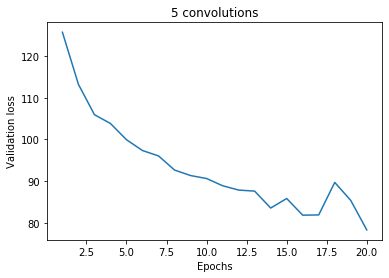

Training time taken: 667.8101134660001 seconds.


In [ ]:
import timeit

setup = """
num_epochs = 20
save_all = False
"""

cpu_train_time = timeit.timeit(
    "train_model(num_epochs, save_all)",
    setup,
    number=1,
    globals=globals(),
)
print('Training time taken: {} seconds.'.format(cpu_train_time))

## Loading and testing model

In [ ]:
! ls

CurrentModel_best.pth  CurrentModel_wo_val.pth	imagenet10  sample_data


In [ ]:
model_gpu = ConvNet5().to(device)
model_gpu.load_state_dict(torch.load('CurrentModel_best.pth'))
tot_labels, tot_predicted, Accuracy = test_model(model_gpu, test_loader)

Accuracy of the network on the test images: 54 %


In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
cm = confusion_matrix(tot_labels.numpy(), tot_predicted.numpy())

Confusion matrix, without normalization


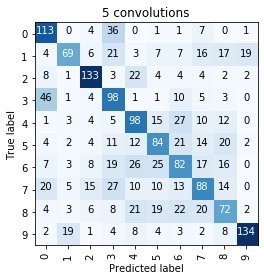

In [ ]:
plot_confusion_matrix(cm, np.arange(0,10))

# Part 2. Filter Visualisation

In [ ]:
! ls

CurrentModel_best.pth  CurrentModel_wo_val.pth	imagenet10  sample_data


In [ ]:
# Pick which model to load
model_gpu = ConvNet5().to(device)
model_gpu.load_state_dict(torch.load('CurrentModel_best.pth'))

<All keys matched successfully>

In [ ]:
weights = model_gpu.cnn_layers[0].weight.cpu().data.numpy()
print(weights[1])

[[[ 0.15242156 -0.16591565 -0.17090513]
  [-0.09144758  0.03344423  0.15691218]
  [ 0.13895443  0.0771251  -0.0231657 ]]

 [[-0.13350484  0.181587   -0.14819078]
  [-0.13696423  0.10837853  0.15713997]
  [ 0.031501   -0.01390062 -0.0215069 ]]

 [[-0.00992202 -0.11213012  0.22181173]
  [ 0.15540178 -0.11618707  0.12235469]
  [-0.12764387 -0.21962033 -0.02160584]]]


The layers need to be normalised and combined. This can be done by summing the three seperate channels.

In [ ]:
def normalise_image(image):
  norm_image = (image -  image.min())/(image.max() -  image.min())
  return(norm_image)

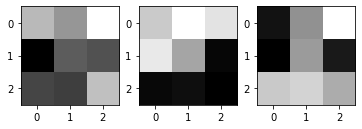

In [ ]:
# red channel
plt.subplot(1,3,1)
plt.imshow(weights[0][0], cmap="gray")
# green channel
plt.subplot(1,3,2)
plt.imshow(weights[0][1], cmap="gray")
# blue channel
plt.subplot(1,3,3)
plt.imshow(weights[0][2], cmap="gray")

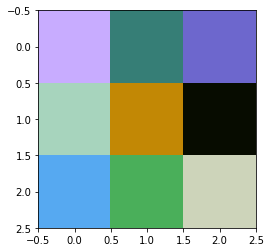

In [ ]:
plt.imshow(normalise_image(weights[0]), cmap="gray")

Normalising

In [ ]:
f_min = weights.min()
f_max = weights.max()
filters = ((weights - f_min) / (f_max - f_min))*255

Plot the normalised filters

<Figure size 432x288 with 0 Axes>

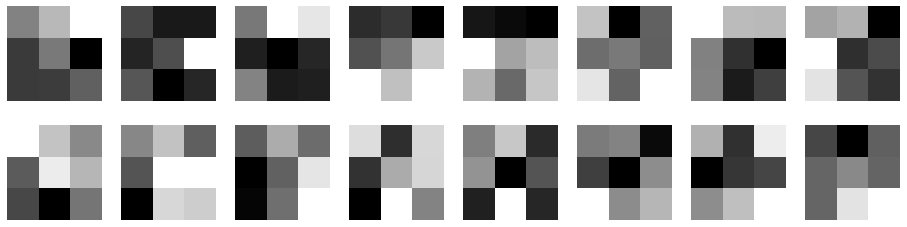

In [ ]:
fig = plt.figure()
plt.figure(figsize=(16,4))
for i, filt in enumerate(filters):
    filt_sum = (filt[0]+filt[1]+filt[2])/3  
    plt.subplot(2,8, i + 1)
    plt.imshow(filt_sum, cmap="gray")
    plt.axis('off')

# Part 3. Feature map visualisation

First gather images to test, from the test and training sets

In [ ]:
images, labels = next(iter(test_loader))

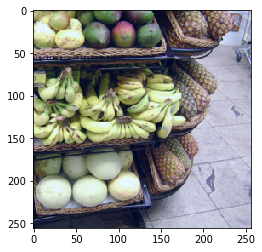

Class for this image is 1: banana


In [ ]:
i = 16
plt.imshow(normalise_image(images[i].permute(1,2,0)))

plt.show()
print('Class for this image is {}: {}'.format(labels[i], class_names[labels[i]]))

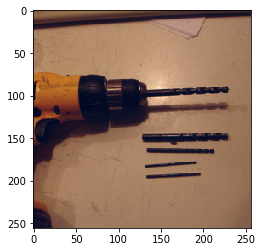

Class for this image is 5: drill


In [ ]:
i = 21
plt.imshow(normalise_image(images[i].permute(1,2,0)))
plt.show()
print('Class for this image is {}: {}'.format(labels[i], class_names[labels[i]]))

Generate feature maps

In [ ]:
model_gpu.cnn_layers[0]

Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))

In [ ]:
model_gpu.cnn_layers[4]

Conv2d(16, 24, kernel_size=(4, 4), stride=(1, 1))

In [ ]:
model_gpu.cnn_layers[8]

Conv2d(24, 32, kernel_size=(4, 4), stride=(1, 1))

In [ ]:
def print_feature_maps(indices, images):
  # Given a set of images, and the indices for the particular images to create
  # maps for:
  # Returns feature maps for each convolutional layer for each indexed image.



  images_dev = images.to(device)
  conv1_activs = model_gpu.cnn_layers[0](images_dev)
  conv2_activs = model_gpu.cnn_layers[4](conv1_activs)
  conv3_activs = model_gpu.cnn_layers[8](conv2_activs)

  for i in indices:
    conv1_image = conv1_activs[i].cpu().detach().clone().numpy()
    conv2_image = conv2_activs[i].cpu().detach().clone().numpy()
    conv3_image = conv3_activs[i].cpu().detach().clone().numpy()

    print('{}'.format(class_names[labels[i]]))
    norm_image = (images[i].permute(1,2,0) -  images[i].min())/(images[i].max() -  images[i].min())
    plt.imshow(norm_image)
    plt.axis('off')
    plt.show()
    plt.figure(figsize=(16,4))
    print('CONVOLUTION 1')
    for k, feature in enumerate(conv1_image):
      plt.subplot(2,8, k+1)
      plt.imshow(feature, cmap="gray")
      plt.axis('off')
    plt.show()

    print('\n'*2)
    print('CONVOLUTION 2:')
    plt.figure(figsize=(16,6))
    for k, feature in enumerate(conv2_image):
      plt.subplot(3,8, k+1)
      plt.imshow(feature, cmap="gray")
      plt.axis('off')
    plt.show()

    print('\n'*2)
    print('CONVOLUTION 3:')
    plt.figure(figsize=(16,8))
    for k, feature in enumerate(conv3_image):
      plt.subplot(4,8, k+1)
      plt.imshow(feature, cmap="gray")
      plt.axis('off')
    plt.show()
    # print('-'*100)
    print('\n'*5)

Print feature maps for image 16 and 21

football


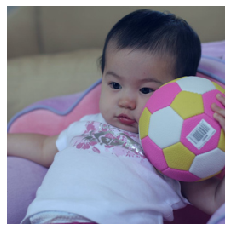

CONVOLUTION 1


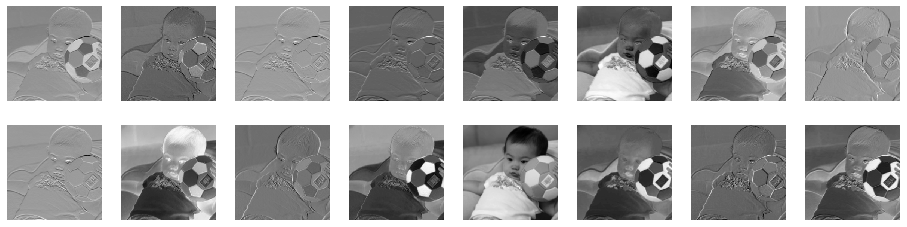




CONVOLUTION 2:


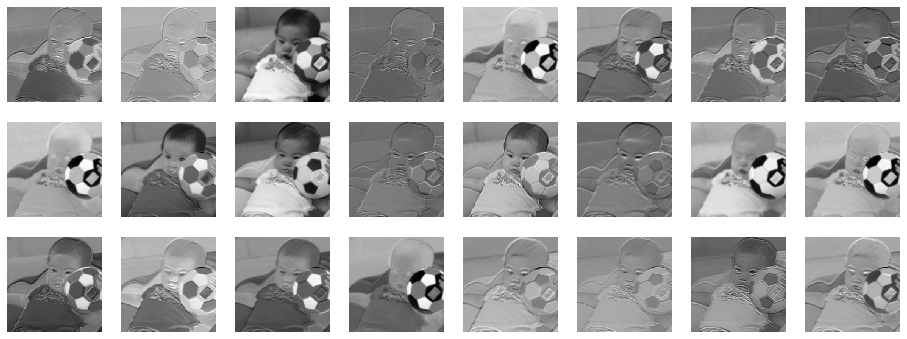




CONVOLUTION 3:


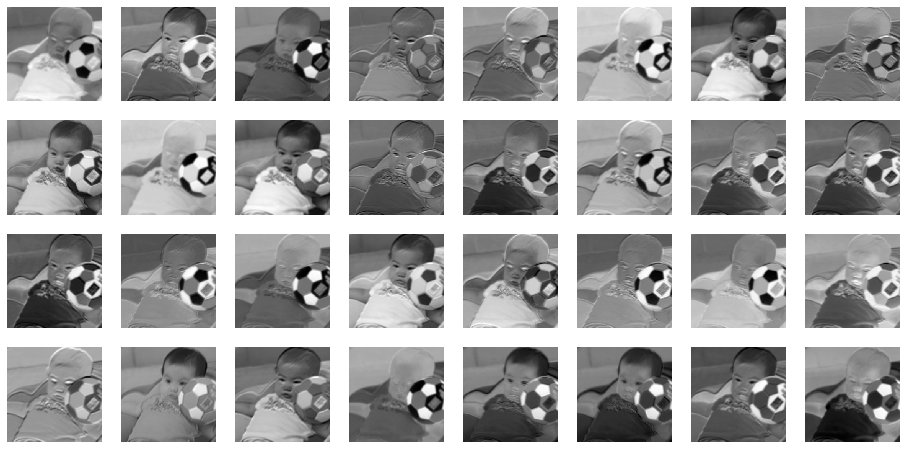







canoe


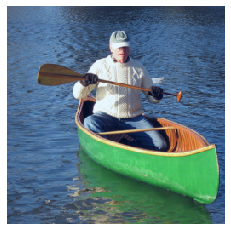

CONVOLUTION 1


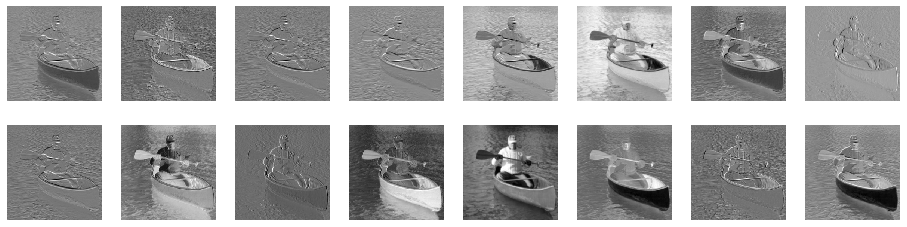




CONVOLUTION 2:


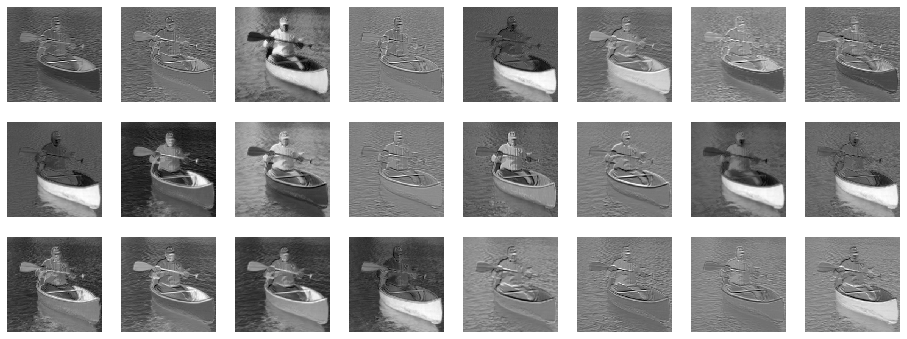




CONVOLUTION 3:


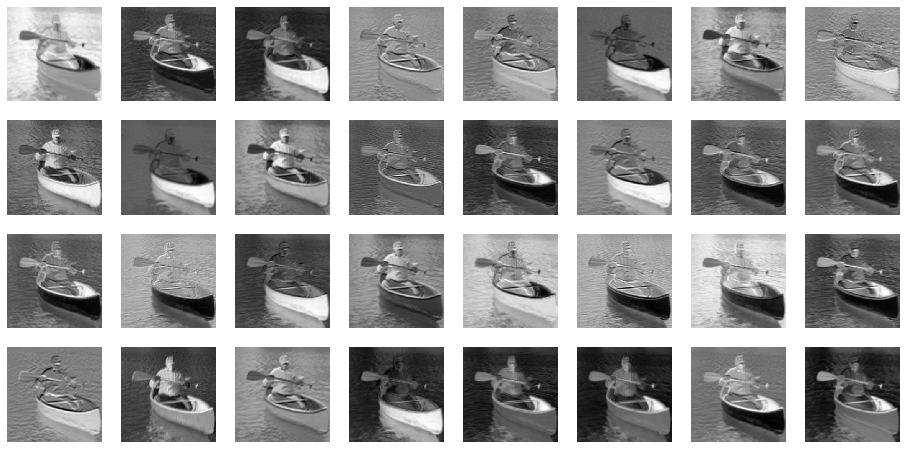

In [ ]:
print_feature_maps([16,21], images)

# Part 4. Improving Network Performance

## Set up

Included set up again so this section can be run on its own.

In [ ]:
import torch
import torchvision
import torch.optim as optim
import torch.nn as nn
import torchvision.transforms as transforms
from  torch.utils.data import Dataset

from sklearn.metrics import confusion_matrix
from skimage import io, transform

import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image
import pandas as pd
import numpy as np
import csv
import os
import math
import cv2

In [ ]:
! git clone https://github.com/MohammedAlghamdi/imagenet10.git
! ls

Cloning into 'imagenet10'...
remote: Enumerating objects: 10019, done.
remote: Total 10019 (delta 0), reused 0 (delta 0), pack-reused 10019
Receiving objects: 100% (10019/10019), 966.71 MiB | 57.19 MiB/s, done.
Resolving deltas: 100% (2/2), done.
Checking out files: 100% (10002/10002), done.
imagenet10  sample_data


In [ ]:
def get_meta(root_dir, dirs):
    """ Fetches the meta data for all the images and assigns labels.
    """
    paths, classes = [], []
    for i, dir_ in enumerate(dirs):
        for entry in os.scandir(root_dir + dir_):
            if (entry.is_file()):
                paths.append(entry.path)
                classes.append(i)
                
    return paths, classes

In [ ]:
class ImageNet10(Dataset):
    """ ImageNet10 dataset. """

    def __init__(self, df, transform=None):
        """
        Args:
            image_dir (string): Directory with all the images
            df (DataFrame object): Dataframe containing the images, paths and classes
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        # Load image from path and get label
        x = Image.open(self.df['path'][index])
        try:
          x = x.convert('RGB') # To deal with some grayscale images in the data
        except:
          pass
        y = torch.tensor(int(self.df['class'][index]))

        if self.transform:
            x = self.transform(x)

        return x, y

In [ ]:
def compute_img_mean_std(image_paths):
    """
        Author: @xinruizhuang. Computing the mean and std of three channel on the whole dataset,
        first we should normalize the image from 0-255 to 0-1
    """

    img_h, img_w = 224, 224
    imgs = []
    means, stdevs = [], []

    for i in tqdm(range(len(image_paths))):
        img = cv2.imread(image_paths[i])
        img = cv2.resize(img, (img_h, img_w))
        imgs.append(img)

    imgs = np.stack(imgs, axis=3)
    print(imgs.shape)

    imgs = imgs.astype(np.float32) / 255.

    for i in range(3):
        pixels = imgs[:, :, i, :].ravel()  # resize to one row
        means.append(np.mean(pixels))
        stdevs.append(np.std(pixels))

    means.reverse()  # BGR --> RGB
    stdevs.reverse()

    print("normMean = {}".format(means))
    print("normStd = {}".format(stdevs))
    return means, stdevs

In [ ]:
root_dir = "imagenet10/train_set/"
class_names = [
  "baboon",
  "banana",
  "canoe",
  "cat",
  "desk",
  "drill",
  "dumbbell",
  "football",
  "mug",
  "orange",
]
# Benign images we will assign class 0, and malignant as 1
paths, classes = get_meta(root_dir, class_names)

data = {
    'path': paths,
    'class': classes
}

data_df = pd.DataFrame(data, columns=['path', 'class'])
data_df = data_df.sample(frac=1).reset_index(drop=True) # Shuffles the data

norm_mean, norm_std = compute_img_mean_std(paths)

data_transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(256),
        transforms.ToTensor(),
        transforms.Normalize(norm_mean, norm_std),
    ])

train_split = 0.70 # Defines the ratio of train/valid/test data.
valid_split = 0.10

train_size = int(len(data_df)*train_split)
valid_size = int(len(data_df)*valid_split)

ins_dataset_train = ImageNet10(
    df=data_df[:train_size],
    transform=data_transform,
)

ins_dataset_valid = ImageNet10(
    df=data_df[train_size:(train_size + valid_size)].reset_index(drop=True),
    transform=data_transform,
)

ins_dataset_test = ImageNet10(
    df=data_df[(train_size + valid_size):].reset_index(drop=True),
    transform=data_transform,
)

100%|██████████| 9000/9000 [00:45<00:00, 198.38it/s]


(224, 224, 3, 9000)
normMean = [0.5228344, 0.47988218, 0.40605018]
normStd = [0.29770824, 0.28884, 0.31178245]


In [ ]:
train_loader = torch.utils.data.DataLoader(
    ins_dataset_train,
    batch_size=16,
    shuffle=True,
    num_workers=2
)

valid_loader = torch.utils.data.DataLoader(
    ins_dataset_valid,
    batch_size=16,
    shuffle=True,
    num_workers=2
)


test_loader = torch.utils.data.DataLoader(
    ins_dataset_test,
    batch_size=24,
    shuffle=False,
    num_workers=2
)

In [ ]:
def train_model_epochs_for_opy(num_epochs, m_name):
  best_val_loss = 100000
  not_improved_count = 0
  for epoch in range(num_epochs):
    # if (not_improved_count == 5):
    #   torch.save(model_gpu.state_dict(), '{}_final.pth'.format(m_name))
    #   return
    print('Epoch {}/{}:'.format(epoch + 1, num_epochs))
    for phase in ['train', 'val']:
        
      if (phase == 'train'):
        loader = train_loader
      else:
        loader = valid_loader

      running_loss = 0.0

      for i, data in enumerate(loader, 0):
        images, labels = data

        # Explicitly specifies that data is to be copied onto the device!
        images = images.to(device)  # <----------- And note it's NOT an in-place operation; original
        labels = labels.to(device)  # <----------- variables still exist on CPU

        # Zero the param gradients
        optimiser.zero_grad()

        # forward pass
        outputs = model_gpu(images)

        # compute loss
        loss = criterion(outputs, labels)

        if phase == 'train':
          # backwards pass (backpropagate the error wrt the lossforward)
          loss.backward()
          # update the parameters
          optimiser.step()

        # print the loss
        running_loss += loss.item()

        if i % 100 == 99:    # print every 100 mini-batches
            print('Batch %d - Loss: %.3f' %
                  (i + 1, running_loss / 100))
            running_loss = 0.0

      if phase == 'val':
          print('Validation loss: {}'.format(running_loss))
          if (running_loss < best_val_loss):
            not_improved_count = 0
            print('Saving model.')
            best_val_loss = running_loss
            torch.save(model_gpu.state_dict(), '{}.pth'.format(m_name))
          else:
            not_improved_count += 1
  torch.save(model_gpu.state_dict(), '{}_final.pth'.format(m_name))

In [ ]:
def run_test(model_gpu, test_loader):
  correct = 0
  total = 0
  tot_predicted = torch.zeros(0,dtype=torch.long, device='cpu')
  tot_labels    = torch.zeros(0,dtype=torch.long, device='cpu')
  # tot_predicted = torch.Tensor()
  # Why don't we need gradients? What happens if we do include gradients?
  with torch.no_grad():
      # Iterate over the test set
      i = 0
      for i, data in enumerate(test_loader, 0):
          # print('iteration {}'.format(i))
        
          images, labels = data

          images = images.to(device)  # <----------- And note it's NOT an in-place operation; original
          labels = labels.to(device)  # <----------- variables still exist on CPU
          
          outputs = model_gpu(images)
          
          # torch.max is an argmax operation
          _, predicted = torch.max(outputs.data, 1)

          total += labels.size(0)
          correct += (predicted == labels).sum().item()

          # Append batch prediction results
          tot_predicted = torch.cat([tot_predicted, predicted.view(-1).cpu()])
          tot_labels    = torch.cat([tot_labels,    labels.view(-1).cpu()])

  print('Accuracy of the network on the test images: %d %%' % (100 * correct / total))
  return tot_labels, tot_predicted

## Final Model

In [ ]:
# Convolutional neural network
class ConvNetImp1(nn.Module):
    
    def __init__(self, num_classes=10):
        super(ConvNetImp1, self).__init__()
  
        # Add network layers here
        self.cnn_layers = nn.Sequential(
            # Convolution 1
            nn.Conv2d(3, 16, kernel_size=(3,3)),
            nn.ReLU(),
            nn.MaxPool2d((2,2)),
            nn.Dropout(p=0.1),
            
            # Convolution 2
            nn.Conv2d(16, 16, kernel_size=(4,4)),
            nn.ReLU(),
            nn.MaxPool2d((2,2)),
            nn.Dropout(p=0.1),

            # Convolution 3
            nn.Conv2d(16, 24, kernel_size=(4,4)),
            nn.ReLU(),
            nn.MaxPool2d((2,2)),
            nn.Dropout(p=0.1),

            # Convolution 4
            nn.Conv2d(24, 32, kernel_size=(2,2)),
            nn.ReLU(),
            nn.MaxPool2d((4,4)),
            nn.Dropout(p=0.1),

            nn.Flatten(),
        )

        self.linear_layers = nn.Sequential(
            nn.Linear(1568, 512),
            nn.Linear(512, num_classes),
        )

        
    def forward(self, x):

        # Complete the graph
        out = self.cnn_layers(x)
        out = self.linear_layers(out)
        return out

## Train

I used 30 epochs, and then tested if it improved by running for another 10 more.

Epoch 1/20:
Batch 100 - Loss: 2.298
Batch 200 - Loss: 2.269
Batch 300 - Loss: 2.225
Validation loss: 115.46973526477814
Saving model.
Epoch 2/20:
Batch 100 - Loss: 1.969
Batch 200 - Loss: 1.930
Batch 300 - Loss: 1.907
Validation loss: 110.5635666847229
Saving model.
Epoch 3/20:
Batch 100 - Loss: 1.863
Batch 200 - Loss: 1.839
Batch 300 - Loss: 1.804
Validation loss: 106.2424488067627
Saving model.
Epoch 4/20:
Batch 100 - Loss: 1.772
Batch 200 - Loss: 1.749
Batch 300 - Loss: 1.702
Validation loss: 104.19938564300537
Saving model.
Epoch 5/20:
Batch 100 - Loss: 1.694
Batch 200 - Loss: 1.647
Batch 300 - Loss: 1.644
Validation loss: 97.78604209423065
Saving model.
Epoch 6/20:
Batch 100 - Loss: 1.625
Batch 200 - Loss: 1.584
Batch 300 - Loss: 1.585
Validation loss: 96.68013453483582
Saving model.
Epoch 7/20:
Batch 100 - Loss: 1.472
Batch 200 - Loss: 1.557
Batch 300 - Loss: 1.573
Validation loss: 92.48754274845123
Saving model.
Epoch 8/20:
Batch 100 - Loss: 1.478
Batch 200 - Loss: 1.540
Batch 3

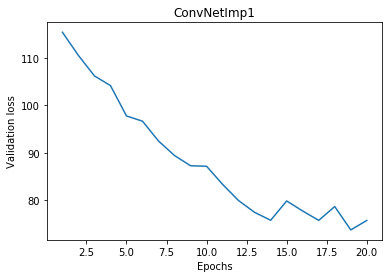

Training time taken: 694.2289549769994 seconds.


In [ ]:
import timeit

torch.manual_seed(0)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model_gpu = ConvNetImp1().to(device)
criterion = nn.CrossEntropyLoss()

# Stochastic gradient descent
optimiser = optim.SGD(model_gpu.parameters(), lr=0.001, momentum=0.9)

name = "ConvNetImp1"
save = "False"

cpu_train_time = timeit.timeit(
    "train_model(num_epochs, name, save)",
    setup="num_epochs=20",
    number=1,
    globals=globals(),
)
print('Training time taken: {} seconds.'.format(cpu_train_time))

In [ ]:
! ls

CConvNetImp1_wo_val.pth     ConvNetImp1_best.pth     imagenet10
CFinal_best_new_wo_val.pth  Final_best_new_best.pth  sample_data
CFinal_wo_val.pth	    Final_best.pth


*Extra training if needed*

Epoch 1/10:
Batch 100 - Loss: 0.917
Batch 200 - Loss: 0.989
Batch 300 - Loss: 0.982
Validation loss: 73.62249314785004
Saving model.
Epoch 2/10:
Batch 100 - Loss: 0.908
Batch 200 - Loss: 0.965
Batch 300 - Loss: 0.963
Validation loss: 73.48235130310059
Saving model.
Epoch 3/10:
Batch 100 - Loss: 0.979
Batch 200 - Loss: 0.954
Batch 300 - Loss: 0.964
Validation loss: 73.36315923929214
Saving model.
Epoch 4/10:
Batch 100 - Loss: 0.968
Batch 200 - Loss: 0.953
Batch 300 - Loss: 0.970
Validation loss: 73.94689512252808
Epoch 5/10:
Batch 100 - Loss: 0.978
Batch 200 - Loss: 0.950
Batch 300 - Loss: 0.964
Validation loss: 73.70465779304504
Epoch 6/10:
Batch 100 - Loss: 0.985
Batch 200 - Loss: 0.937
Batch 300 - Loss: 0.951
Validation loss: 72.39927971363068
Saving model.
Epoch 7/10:
Batch 100 - Loss: 0.889
Batch 200 - Loss: 1.030
Batch 300 - Loss: 0.997
Validation loss: 73.29422789812088
Epoch 8/10:
Batch 100 - Loss: 0.958
Batch 200 - Loss: 0.965
Batch 300 - Loss: 0.934
Validation loss: 74.1475011

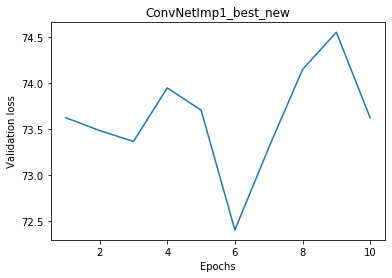

Training time taken: 343.11006276899934 seconds.


In [ ]:
name = "ConvNetImp1_best"
new_name = name + "_new"
num_epochs = 10
save = False

model_gpu = ConvNetImp1().to(device)
model_gpu.load_state_dict(torch.load('{}.pth'.format(name)))
cpu_train_time = timeit.timeit(
    "train_model(num_epochs, new_name, save)",
    # setup="num_epochs=5",
    number=1,
    globals=globals(),
)
print('Training time taken: {} seconds.'.format(cpu_train_time))

## Test

In [ ]:
model_gpu = ConvNetImp1().to(device)
model_gpu.load_state_dict(torch.load('ConvNetImp1_best_new_best.pth'))
tot_labels, tot_predicted, accuracy = test_model(model_gpu, test_loader)

Accuracy of the network on the test images: 57 %


In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
cm = confusion_matrix(tot_labels.numpy(), tot_predicted.numpy())

In [ ]:
import itertools

def plot_confusion_matrix(cm,
                          classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix very prettily.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)

    # Specify the tick marks and axis text
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    # The data formatting
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    
    # Print the text of the matrix, adjusting text colour for display
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

Confusion matrix, without normalization


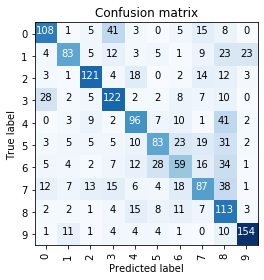

In [ ]:
plot_confusion_matrix(cm, np.arange(0,10))

2nd improvement

Epoch 1/30:
Batch 100 - Loss: 2.297
Batch 200 - Loss: 2.268
Batch 300 - Loss: 2.222
Validation loss: 115.29796528816223
Saving model.
Epoch 2/30:
Batch 100 - Loss: 1.965
Batch 200 - Loss: 1.925
Batch 300 - Loss: 1.900
Validation loss: 110.49171328544617
Saving model.
Epoch 3/30:
Batch 100 - Loss: 1.849
Batch 200 - Loss: 1.822
Batch 300 - Loss: 1.783
Validation loss: 105.52049005031586
Saving model.
Epoch 4/30:
Batch 100 - Loss: 1.762
Batch 200 - Loss: 1.733
Batch 300 - Loss: 1.694
Validation loss: 104.04860150814056
Saving model.
Epoch 5/30:
Batch 100 - Loss: 1.682
Batch 200 - Loss: 1.634
Batch 300 - Loss: 1.636
Validation loss: 96.12545430660248
Saving model.
Epoch 6/30:
Batch 100 - Loss: 1.612
Batch 200 - Loss: 1.579
Batch 300 - Loss: 1.569
Validation loss: 95.50214576721191
Saving model.
Epoch 7/30:
Batch 100 - Loss: 1.456
Batch 200 - Loss: 1.550
Batch 300 - Loss: 1.555
Validation loss: 91.213742852211
Saving model.
Epoch 8/30:
Batch 100 - Loss: 1.453
Batch 200 - Loss: 1.515
Batch 3

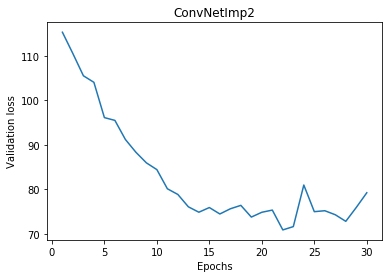

Training time taken: 1066.0464582799996 seconds.


In [ ]:
import timeit

torch.manual_seed(0)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model_gpu = ConvNetImp1().to(device)
criterion = nn.CrossEntropyLoss()

# Stochastic gradient descent
optimiser = optim.SGD(model_gpu.parameters(), lr=0.001, momentum=0.9,  nesterov=True)

name = "ConvNetImp2"
save = "False"

cpu_train_time = timeit.timeit(
    "train_model(num_epochs, name, save)",
    setup="num_epochs=30",
    number=1,
    globals=globals(),
)
print('Training time taken: {} seconds.'.format(cpu_train_time))

In [ ]:
model_gpu = ConvNetImp1().to(device)
model_gpu.load_state_dict(torch.load('ConvNetImp2_best.pth'))
tot_labels, tot_predicted, accuracy = test_model(model_gpu, test_loader)

Accuracy of the network on the test images: 58 %


Epoch 1/10:
Batch 100 - Loss: 0.812
Batch 200 - Loss: 0.904
Batch 300 - Loss: 0.869
Validation loss: 70.60869109630585
Saving model.
Epoch 2/10:
Batch 100 - Loss: 0.805
Batch 200 - Loss: 0.858
Batch 300 - Loss: 0.881
Validation loss: 70.6920405626297
Epoch 3/10:
Batch 100 - Loss: 0.890
Batch 200 - Loss: 0.844
Batch 300 - Loss: 0.867
Validation loss: 70.29186028242111
Saving model.
Epoch 4/10:
Batch 100 - Loss: 0.888
Batch 200 - Loss: 0.846
Batch 300 - Loss: 0.863
Validation loss: 70.87764078378677
Epoch 5/10:
Batch 100 - Loss: 0.874
Batch 200 - Loss: 0.858
Batch 300 - Loss: 0.866
Validation loss: 69.79854834079742
Saving model.
Epoch 6/10:
Batch 100 - Loss: 0.887
Batch 200 - Loss: 0.879
Batch 300 - Loss: 0.834
Validation loss: 69.92310726642609
Epoch 7/10:
Batch 100 - Loss: 0.820
Batch 200 - Loss: 0.916
Batch 300 - Loss: 0.900
Validation loss: 70.92063090205193
Epoch 8/10:
Batch 100 - Loss: 0.856
Batch 200 - Loss: 0.886
Batch 300 - Loss: 0.833
Validation loss: 71.46609228849411
Epoch 9

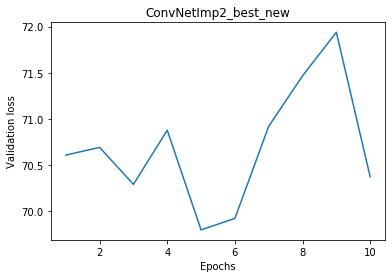

Training time taken: 356.2483227089997 seconds.


In [ ]:
name = "ConvNetImp2_best"
new_name = name + "_new"
num_epochs = 10
save = False

model_gpu = ConvNetImp1().to(device)
model_gpu.load_state_dict(torch.load('{}.pth'.format(name)))
cpu_train_time = timeit.timeit(
    "train_model(num_epochs, new_name, save)",
    # setup="num_epochs=10",
    number=1,
    globals=globals(),
)
print('Training time taken: {} seconds.'.format(cpu_train_time))

In [ ]:
model_gpu = ConvNetImp1().to(device)
model_gpu.load_state_dict(torch.load('ConvNetImp2_best_new_best.pth'))
tot_labels, tot_predicted, accuracy = test_model(model_gpu, test_loader)

Accuracy of the network on the test images: 58 %


Confusion matrix, without normalization


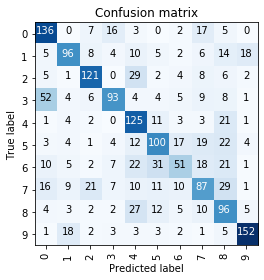

In [ ]:
cm = confusion_matrix(tot_labels.numpy(), tot_predicted.numpy())
plot_confusion_matrix(cm, np.arange(0,10))